In [3]:
import numpy as np

In [4]:
# Load the data
locations = np.loadtxt("C:\\Users\\niels\\OneDrive\\Documenten\\GitHub\\revolve2\\locations.csv",
                  delimiter = ',')

concentrations = {}
for tf in range(1, 6):
    # concentrations[tf] = np.loadtxt(f"C:\\Users\\niels\\OneDrive\\Documenten\\GitHub\\revolve2\\concentrations_TF{tf}.csv",
    #               delimiter = ',')
    concentrations[tf] = np.loadtxt(f"C:\\Users\\niels\\OneDrive\\Documenten\\GitHub\\revolve2\\concentrations_GRN_TF{tf}.csv",
                  delimiter = ',')


#[cell.developed_module.substrate_coordinates[0], cell.developed_module.substrate_coordinates[1], 
#        slot4coordinates, potential_module_coord[0], potential_module_coord[1]]

# FRONT = 0
# RIGHT = 1
# BACK = 2
# LEFT = 3

In [5]:
coordinates, directions = [], {}
# Append core coordinates --> 3 x 3 central grid
for coord in [(-1, -1), (-1, 1), (1, -1), (1, 1), (0, 0)]:
    coordinates.append([coord[0], coord[1]])

xbounds = [0, 0]
ybounds = [0, 0]
for loc in locations:
    coordinates.append([loc[3], loc[4]])
    directions[tuple(coordinates[-1])] = {0: (int(np.sign(loc[3] - loc[0])), int(np.sign(loc[4] - loc[1])))}
    directions[tuple(coordinates[-1])][2] = (-int(np.sign(loc[3] - loc[0])), -int(np.sign(loc[4] - loc[1])))
    
    if (directions[tuple(coordinates[-1])][0] == (1, 0)):
        directions[tuple(coordinates[-1])][1] = (0, 1)
        directions[tuple(coordinates[-1])][3] = (0, -1)
    elif (directions[tuple(coordinates[-1])][0] == (0, 1)):
        directions[tuple(coordinates[-1])][1] = (-1, 0)
        directions[tuple(coordinates[-1])][3] = (1, 0)
    elif (directions[tuple(coordinates[-1])][0] == (-1, 0)):
        directions[tuple(coordinates[-1])][1] =  (0, -1)
        directions[tuple(coordinates[-1])][3] = (0, 1)
    elif (directions[tuple(coordinates[-1])][0] == (0, -1)):
        directions[tuple(coordinates[-1])][1] = (1, 0)
        directions[tuple(coordinates[-1])][3] = (-1, 0)
    else:
        print("Error")

    
    # x-coordinate
    try:
        assert directions[tuple(coordinates[-1])][0][0] + loc[0] == loc[3]
    except:
        assert directions[tuple(coordinates[-1])][0][0] * 2 + loc[0] == loc[3]
    # y-coordinate
    try:
        assert directions[tuple(coordinates[-1])][0][1] + loc[1] == loc[4]
    except:
        assert directions[tuple(coordinates[-1])][0][1] * 2 + loc[1] == loc[4]

    
    # Store bounds
    if loc[3] < xbounds[0]:
        xbounds[0] = loc[3]
    if loc[3] > xbounds[1]:
        xbounds[1] = loc[3]
    if loc[4] < ybounds[0]:
        ybounds[0] = loc[4]
    if loc[4] > ybounds[1]:
        ybounds[1] = loc[4]

# Append slot coordinates
xbounds = [min([xbounds[0], - 1]), max([xbounds[1], 1])]
ybounds = [min([ybounds[0], - 1]), max([ybounds[1], 1])]

In [6]:
grid = np.ones((max([int(xbounds[1] - xbounds[0]) + 1, 3]), max([int(ybounds[1] - ybounds[0] + 1), 3])))

# Set to 0 if not in body
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if [i + xbounds[0], j + ybounds[0]] not in coordinates:
            grid[i, j] = 0

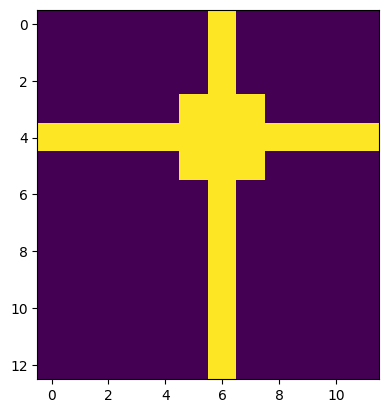

In [7]:
import matplotlib.pyplot as plt
plt.imshow(grid)

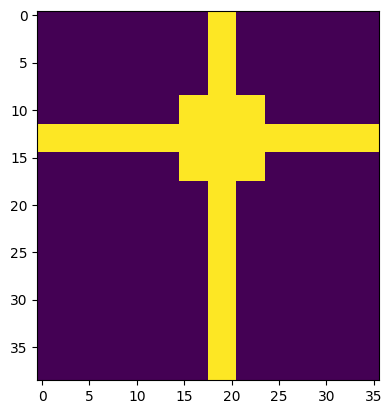

In [8]:
# Expand each grid cell to 3 x 3
expanded_grid = np.zeros((grid.shape[0] * 3, grid.shape[1] * 3))
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        expanded_grid[i * 3: (i + 1) * 3, j * 3: (j + 1) * 3] = grid[i, j]

plt.imshow(expanded_grid)

In [54]:
# Write gif of the concentrations --> normalized per timestep
import gif

@gif.frame
def animate(gen):
    # ---- Plot
    # Initialize figure
    fig = plt.figure(figsize=(20, 20), facecolor = "white")
    ax = [fig.add_subplot(2, 3, i + 1) for i in range(0, 6)]
    fig.tight_layout()
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=8, hspace=None)
    # Initialize color map and norm
    cmap = plt.colormaps.get_cmap("jet")
    minval = 0
    maxval = np.max([np.max(concentrations[tf][:, gen]) for tf in range(1, 6)])

    for tf in range(1, 6):
        # Initialize grid
        expanded_grid = np.zeros((grid.shape[0] * 3, grid.shape[1] * 3))

        # Set the concentrations on an expanded grid for TF1
        middle_core = 0
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                # # Save core index?
                # if (i + xbounds[0], j + ybounds[0]) == (0, 0):
                #     core_index = [i * 3, j * 3]
                
                if (grid[i, j] == 1) and ((i + xbounds[0], j + ybounds[0]) not in [(0, 0), (1, 1), (-1, -1), (-1, 1), (1, -1)]):
                    # Get index of the coordinates
                    idx_coordinates = coordinates.index([i + xbounds[0], j + ybounds[0]])
                    idx = idx_coordinates - 8 # Subtract 8 to get the correct index for the concentrations
                    # Check if core
                    if idx <= 0:
                        bool_core = True
                        idx += 3
                    else:
                        bool_core = False

                    # Tijdelijk --> core nog toevoegen
                    if not bool_core:
                        for c in range(4):
                            row = i * 3 + 1 + directions[tuple(coordinates[idx_coordinates])][c][0]
                            col = j * 3 + 1 + directions[tuple(coordinates[idx_coordinates])][c][1]
                            expanded_grid[row, col] = concentrations[1][int(idx * 4 + c), gen]
                    else:
                        row = i * 3
                        col = j * 3
                        expanded_grid[row:int(row + 3), col:int(col + 3)] = concentrations[tf][int(idx * 4), gen]
                        middle_core += 0.25 * concentrations[tf][int(idx * 4), gen]

        #expanded_grid[core_index[0]:core_index[0] + 3, core_index[1]:core_index[1] + 3] = middle_core
        # ---- Plot
        ax[int(tf - 1)].imshow(expanded_grid, cmap = cmap, vmin = minval, vmax = maxval)
        ax[int(tf - 1)].set_title(f"TF{tf}, t = {gen}", fontsize = 20, pad = 20, color = "black", fontweight = "bold")
        ax[int(tf - 1)].axis("off")
        ax[int(tf - 1)].set_aspect("equal")
        ax[int(tf - 1)].set_xticklabels([])
        ax[int(tf - 1)].set_yticklabels([])
        # Remove tick indicators
        ax[int(tf - 1)].set_xticks([])
        ax[int(tf - 1)].set_yticks([])
    
    # ---- Set last figure blank
    ax[5].axis("off")
    ax[5].set_aspect("equal")
    ax[5].set_xticklabels([])
    ax[5].set_yticklabels([])
    # Remove tick indicators
    ax[5].set_xticks([])
    ax[5].set_yticks([])

frames = []
for i in range(1024, 1034): #concentrations[1].shape[1]):
    # Print progress
    print(f"Frame {i} of {concentrations[1].shape[1]}", end = "\r")
    # Append
    frames.append(animate(i))
    
# ----- Export gif
gif.save(frames, f"Tfs.gif", duration = 300)


In [59]:
print(concentrations[4][4:10, 1031])

[1.0416   0.       0.       1.060225 0.8985   0.      ]
